# VI - Calculating areas of change and confidence intervals
### This script serves to perform a quick estimation of areas and confidence intervals for all types of change using validated data
### This script requires a m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

### 1 - Read files and set parameters

### read the output merged file from the previous script 5e

In [5]:
#DRC
#df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_merge.csv', low_memory=False)
#GAB
df = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv', low_memory=False)

In [2]:
z_score = 1.647

In [3]:
def calculate_areas(df_merged, kozak_column, target_column, total_area):
    
    df_full = df_merged.copy()
    #df_merged = df_merged[df_merged['interpreted'] == 1]
    
    # get all attributes
    categories = df_merged[target_column].unique()
    print(categories)
    # get strata
    strata, d = df_merged[kozak_column].unique(), {}
    
    # create stats for each entry
    for category in categories:
        
        if str(category) == 'nan':
            continue
            
        print(f' Calculating stats for {category}')
        # create binary class column
        df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)
        print(f'There are {df_merged[category].sum()} entries of {category} in {target_column}.')
        
        # initialize variables for category
        categories_area, se_total = 0, 0
        d2 = {}
        for stratum in strata:
                        
            if str(stratum) == 'nan':
                continue
            
            # subset to stratum
            strat_df = df_full[df_full[kozak_column] == stratum]
            
            # get area proportion for that stratum on full dataset
            proportion_strata = len(strat_df)/len(df_full)

            # get stratum area
            stratum_area = proportion_strata * total_area

            # get proportion of forest change within strata from interpreted data
            proportion_category = len(
                df_merged[(df_merged[kozak_column] == stratum) & (df_merged[category] == 1)]
            ) / len(
                df_merged[df_merged[kozak_column] == stratum]
            )
            
            # get area from proportion and full area
            area = proportion_category * stratum_area

            # get error from interpreted data for full stratum area
            var = np.var(df_merged[category][df_merged[kozak_column] == stratum]) / len(df_merged[df_merged[kozak_column] == stratum])
            se = np.sqrt(var) * stratum_area

            # add for totals
            categories_area += area
            se_total += se**2
            
            # add to dictionary
            d2[f'area_stratum_{stratum}'] = area
            d2[f'ci_stratum_{stratum}']=1.67*se
        
        d2['area_total'] = categories_area
        d2['ci_total'] = z_score*np.sqrt(se_total)
        d2['perc_error'] = np.sqrt(se_total) / categories_area * 100
        d[category] = d2
    
    
    return pd.DataFrame.from_dict(d, orient='index')

In [6]:
print(df.columns.values)

['Unnamed: 0' 'images' 'mon_images' 'bfast_change_date' 'bfast_magnitude'
 'bfast_means' 'cusum_change_date' 'cusum_confidence' 'cusum_magnitude'
 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean' 'nir_sd' 'nir_min'
 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min' 'swir1_max' 'swir2_mean'
 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean' 'ndfi_sd' 'ndfi_min'
 'ndfi_max' 'brightness_mean' 'brightness_sd' 'brightness_min'
 'brightness_max' 'greenness_mean' 'greenness_sd' 'greenness_min'
 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min' 'wetness_max'
 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ccdc_change_date' 'ccdc_magnitude' 'aspect' 'dw_class_mode'
 'dw_tree_prob__max' 'dw_tree_prob__min' 'dw_tree_prob__stdDev'
 'dw_tree_prob_mean' 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17'
 'esri_lc18' 'esri_lc19' 'esri_lc20' 'esri_lc21' 'gfc_gain' 'gfc_loss'
 'gfc_lossyear' 'gfc_tc00' 'lang_tree_height' 'potapov_tree_height'
 'slope' 'tmf_2016' 'tmf_2017' 'tmf_2018' 'tmf_

In [7]:
print(len(df))

222878


In [8]:
value_counts = df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()
print(value_counts)

Def2016       165
Def2017        97
Def2018       102
Def2019        89
Def2020       109
Def2021       115
Def2022       155
Deg2016       129
Deg2017       190
Deg2018       200
Deg2019       182
Deg2020       240
Deg2021       185
Deg2022       210
NF          33181
Stable     187529
Name: Sim_CEO_Ref_Change_Year_1522, dtype: int64


#### use these strata counts for area estimation

In [9]:
strata_counts = df['stratum'].value_counts().sort_index()
print(strata_counts)

1.0    169047
2.0     43683
3.0     10148
Name: stratum, dtype: int64


#### enter area of study in ha calculated in GIS or from LSIB for country or area of interest

In [10]:
#DRC forest mask applied
#study_area = 62009300
#CMR forest mask applied
#study_area = 39709141
#GAB
study_area = 26287600
#EQG
#study_area = 2685800
#COG
#study_area = 25361094
#CAR forest mask applied
#study_area = 58889539


### calculate for all years

#### column names:
##### Sim_Ref_Change_Year_1522 - modeled change type and year
##### Sim_CEO_Ref_Change_Year_1522 - hybrid column combining interpreted points and a model for all uninterpreted points
##### Sim_Ref_Change_Type_1522 - modeled change class (def, deg, stable, nf)
##### Sim_CEO_Ref_Change_Type_1522 - hybrid column combining interpreted points and modeled change class (def, deg, stable, nf) for all points

In [50]:
#select column to analyze
column = 'Sim_CEO_Ref_Change_Year_1522'

In [51]:
interpreted = [
    'Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021', 'Def2022',
    'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020', 'Deg2021',
    'Deg2022', 'NF', 'Stable'
]

#df['interpreted'] = df['ChangeYear'].apply(lambda x: 1 if str(x) in interpreted else 0)
df['accumulated'] = df[column].apply(
    lambda x: 'Deforestation' if str(x).startswith('Def') else 'Degradation' if str(x).startswith('Deg') else 'Stable' if str(x).startswith('Sta') else 'NF'if str(x).startswith('NF') else "")
stats_gdf = calculate_areas(df, 'stratum', 'accumulated', study_area).sort_index()

['Stable' 'NF' 'Degradation' 'Deforestation']
 Calculating stats for Stable
There are 187529 entries of Stable in accumulated.
 Calculating stats for NF
There are 33181 entries of NF in accumulated.
 Calculating stats for Degradation
There are 1336 entries of Degradation in accumulated.
 Calculating stats for Deforestation
There are 832 entries of Deforestation in accumulated.


In [26]:
np.unique(df['accumulated'], return_counts=True)

(array(['Deforestation', 'Degradation', 'NF', 'Stable'], dtype=object),
 array([   832,   1336,  33181, 187529]))

In [27]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
stats_df_all[['area_total', 'ci_total', 'perc_error']]
#stats_gdf['Sim_Ref_Change_Year_1522'] = stats_gdf.index

,area_total,ci_total,perc_error
Deforestation,98131.189,5419.822,3.353
Degradation,157576.044,6653.064,2.564
NF,3913570.902,29522.110,0.458
Stable,22118321.864,28996.489,0.080


In [28]:
stats_df_all

,area_stratum_1.0,ci_stratum_1.0,area_stratum_2.0,ci_stratum_2.0,area_stratum_3.0,ci_stratum_3.0,area_total,ci_total,perc_error
Deforestation,353.838,341.159,10968.991,1897.487,86808.360,5146.238,98131.189,5419.822,3.353
Degradation,0.000,0.000,5897.307,1391.991,151678.737,6600.796,157576.044,6653.064,2.564
NF,1352488.398,20364.414,1827693.400,19696.008,733389.104,9665.662,3913570.902,29522.110,0.458
Stable,18585599.051,20366.884,3307681.576,19736.423,225041.237,7752.875,22118321.864,28996.489,0.080


### calculate for each year

In [ ]:
#select column to analyze
column = 'Sim_CEO_Ref_Change_Year_1522'

In [44]:
interpreted = [
    'Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021', 'Def2022',
    'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020', 'Deg2021',
    'Deg2022', 'NF', 'Stable'
]

df['interpreted'] = df[column].apply(lambda x: 1 if str(x) in interpreted else "")
#df['accumulated'] = df['ChangeYear'].apply(
#    lambda x: 'Deforestation' if str(x).startswith('Def') else 'Degradation' if str(x).startswith('Deg') else 'Stable' if str(x).startswith('Sta') else 'NF')

stats_df_year = calculate_areas(df, 'stratum', column, study_area).sort_index()

['Stable' 'NF' 'Deg2021' 'Deg2016' 'Deg2018' 'Def2020' 'Def2019' 'Def2018'
 'Deg2020' 'Def2016' 'Deg2017' 'Def2017' 'Deg2019' 'Def2021' 'Def2022'
 'Deg2022']
 Calculating stats for Stable
There are 185825 entries of Stable in Sim_Ref_Change_Year_1522.
 Calculating stats for NF
There are 34584 entries of NF in Sim_Ref_Change_Year_1522.
 Calculating stats for Deg2021
There are 218 entries of Deg2021 in Sim_Ref_Change_Year_1522.
 Calculating stats for Deg2016
There are 148 entries of Deg2016 in Sim_Ref_Change_Year_1522.
 Calculating stats for Deg2018
There are 220 entries of Deg2018 in Sim_Ref_Change_Year_1522.
 Calculating stats for Def2020
There are 130 entries of Def2020 in Sim_Ref_Change_Year_1522.
 Calculating stats for Def2019
There are 105 entries of Def2019 in Sim_Ref_Change_Year_1522.
 Calculating stats for Def2018
There are 106 entries of Def2018 in Sim_Ref_Change_Year_1522.
 Calculating stats for Deg2020
There are 274 entries of Deg2020 in Sim_Ref_Change_Year_1522.
 Calculating

In [45]:
stats_df_year

,area_stratum_1.0,ci_stratum_1.0,area_stratum_2.0,ci_stratum_2.0,area_stratum_3.0,ci_stratum_3.0,area_total,ci_total,perc_error
Def2016,0.000,0.000,1061.515,590.849,20168.790,2553.924,21230.305,2585.277,7.394
Def2017,0.000,0.000,707.677,482.443,11794.614,1959.972,12502.291,1990.675,9.668
Def2018,0.000,0.000,1769.192,762.731,10733.099,1870.531,12502.291,1992.239,9.675
Def2019,117.946,196.969,2476.869,902.413,9789.530,1787.129,12384.345,1984.004,9.727
Def2020,235.892,278.556,1651.246,736.876,13445.860,2091.219,15332.998,2203.899,8.727
Def2021,0.000,0.000,2123.031,835.501,13327.914,2082.130,15450.944,2212.609,8.695
Def2022,0.000,0.000,1651.246,736.876,21230.305,2619.089,22881.551,2683.303,7.120
Deg2016,0.000,0.000,235.892,278.551,17220.137,2362.816,17456.029,2346.411,8.161
Deg2017,0.000,0.000,235.892,278.551,25594.313,2870.360,25830.205,2844.126,6.685
Deg2018,0.000,0.000,471.785,393.922,25476.366,2863.883,25948.151,2851.033,6.671


In [47]:
stats_df_year['Sim_Ref_Change_Year_1522'] = stats_df.index
#stats_df
stats_df_year.columns

Index(['area_stratum_1.0', 'ci_stratum_1.0', 'area_stratum_2.0',
       'ci_stratum_2.0', 'area_stratum_3.0', 'ci_stratum_3.0', 'area_total',
       'ci_total', 'perc_error', 'Sim_CEO_Ref_Change_Year_1522',
       'Sim_Ref_Change_Year_1522'],
      dtype='object')

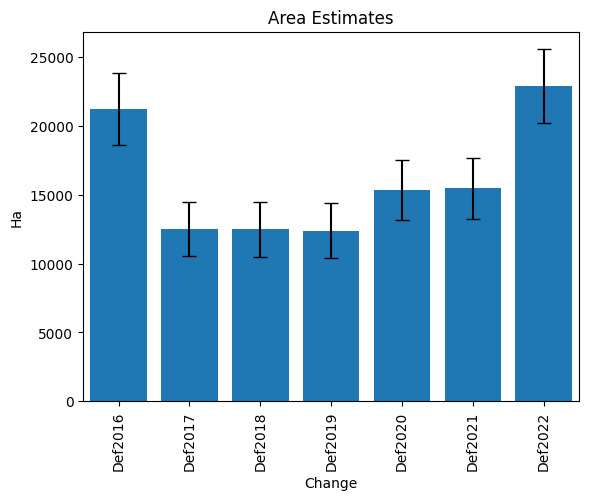

In [48]:
#plot DEF 
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
Def_areas = stats_df_year[stats_df_year['Sim_Ref_Change_Year_1522'].isin(values_to_plot)]

# Create a bar chart
ax = Def_areas.plot(kind='bar', x='Sim_Ref_Change_Year_1522', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Def_areas['Sim_Ref_Change_Year_1522'], Def_areas['area_total'], yerr=Def_areas['ci_total'], capsize=5)  # Add error bars

# Show the plot
plt.show()

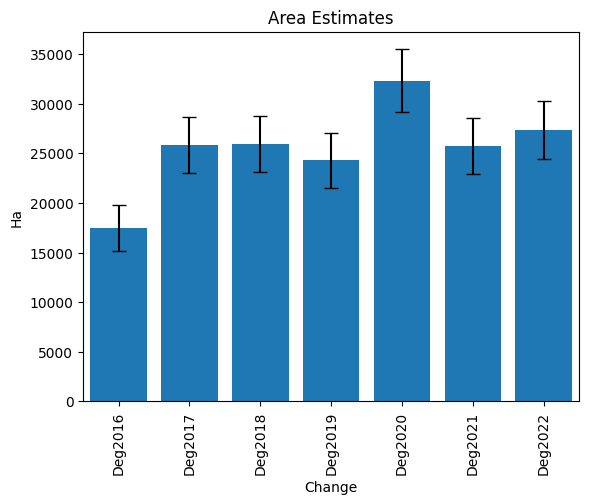

In [49]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
Deg_areas = stats_df_year[stats_df_year['Sim_Ref_Change_Year_1522'].isin(values_to_plot)]

# Create a bar chart
ax = Deg_areas.plot(kind='bar', x='Sim_Ref_Change_Year_1522', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Deg_areas['Sim_Ref_Change_Year_1522'], Deg_areas['area_total'], yerr=Deg_areas['ci_total'], capsize=5)  # Add error bars
# Show the plot
plt.show()

### export stats to csv

In [ ]:
grouped_out =  '/home/sepal-user/module_results/esbae/GAB/GAB_total_stats_2015_2022.csv'
stats_df_all.to_csv(grouped_out,index=True)

In [ ]:
annual_out =  '/home/sepal-user/module_results/esbae/GAB/GAB_annual_stats_2015_2022.csv'
stats_df_year.to_csv(annual_out,index=True)